In [1]:
import os
import pandas as pd
import numpy as np
import kaggle
from zipfile import ZipFile
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import joblib
# Suppress unimportant warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


In [2]:
# Set the path for the dataset folder
folder = '../dataset'
os.makedirs(folder, exist_ok=True)
dataset_file = os.path.join(folder, 'creditcard.csv')

In [3]:
# Load the processed data
processed_data_path = os.path.join(folder, "processed_data.csv")
data = pd.read_csv(processed_data_path)



In [4]:
# Prepare features and target
X = data.drop('Class', axis=1)
y = data['Class']


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [6]:
# Convert the dataset into DMatrix (internal format used by XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [7]:
# Define XGBoost parameters with class_weight adjustment for imbalance
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',  # Use GPU-accelerated histogram-based method
    'predictor': 'gpu_predictor',  # Use GPU for prediction
    'gpu_id': 0,  # Use the first GPU (if you have multiple)
    'scale_pos_weight': np.sum(y_train == 0) / np.sum(y_train == 1)  # Handling class imbalance
}

In [8]:
# Perform Hyperparameter Tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [9]:
# Initialize the model
xgb_model = xgb.XGBClassifier(tree_method='hist', predictor='gpu_predictor', gpu_id=0)

In [10]:
# Use StratifiedKFold for balanced cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters from GridSearchCV
print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters from GridSearchCV: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}


In [11]:
# Train the model with the best parameters
best_model = grid_search.best_estimator_

In [12]:
# Make predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [13]:
# Convert predictions to binary values (fraud or not)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba]

In [14]:
# Evaluation Metrics
def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

# Evaluate XGBoost Model
evaluate_model(y_test, y_pred, "XGBoost")


XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

Confusion Matrix:
[[85259    36]
 [    0 85294]]


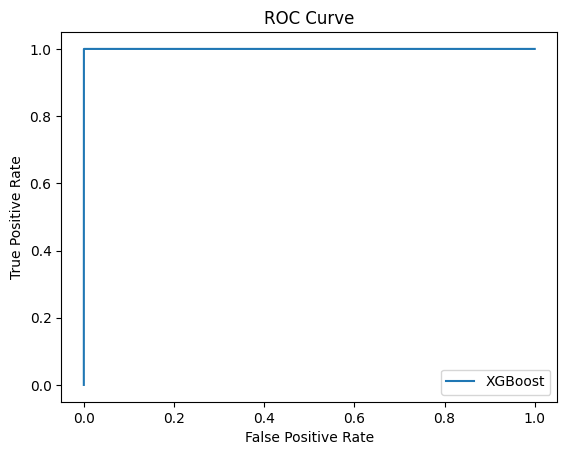

In [15]:
# ROC Curve for XGBoost
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [16]:
# Save the Model
joblib.dump(best_model, 'fraud_detection_xgboost_model.pkl')

['fraud_detection_xgboost_model.pkl']